# Setup

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Raw data download

In [8]:
from zipfile import ZipFile

In [9]:
with ZipFile('kagglecatsanddogs_3367a.zip', 'r') as zipObj:
       zipObj.extractall()

In [10]:
!dir

 ’®¬ ў гбва®©бвўҐ C ­Ґ Ё¬ҐҐв ¬ҐвЄЁ.
 ‘ҐаЁ©­л© ­®¬Ґа в®¬ : 80B1-0A6C

 ‘®¤Ґа¦Ё¬®Ґ Ї ЇЄЁ C:\Users\User\PycharmProjects\pythonProject1

09.07.2021  14:55    <DIR>          .
09.07.2021  14:55    <DIR>          ..
09.07.2021  14:51    <DIR>          .idea
06.07.2021  21:26    <DIR>          .ipynb_checkpoints
06.07.2021  22:03       824я894я548 kagglecatsanddogs_3367a.zip
06.07.2021  21:12               544 main.py
09.07.2021  14:59            35я545 MSR-LA - 3467.docx
09.07.2021  14:55         1я127я263 nn-image-classification.ipynb
06.07.2021  22:18    <DIR>          PetImages
09.07.2021  14:59               104 readme[1].txt
07.07.2021  10:26        33я623я048 save_at_1.h5
07.07.2021  13:34        33я623я048 save_at_10.h5
07.07.2021  13:55        33я623я048 save_at_11.h5
07.07.2021  14:16        33я623я048 save_at_12.h5
07.07.2021  14:36        33я623я048 save_at_13.h5
07.07.2021  14:57        33я623я048 save_at_14.h5
07.07.2021  15:18        33я623я048 save_at_15.h5
07.07.2021  15:38  

In [11]:
!dir PetImages

 ’®¬ ў гбва®©бвўҐ C ­Ґ Ё¬ҐҐв ¬ҐвЄЁ.
 ‘ҐаЁ©­л© ­®¬Ґа в®¬ : 80B1-0A6C

 ‘®¤Ґа¦Ё¬®Ґ Ї ЇЄЁ C:\Users\User\PycharmProjects\pythonProject1\PetImages

06.07.2021  22:18    <DIR>          .
06.07.2021  22:18    <DIR>          ..
09.07.2021  14:59    <DIR>          Cat
09.07.2021  14:59    <DIR>          Dog
               0 д ©«®ў              0 Ў ©в
               4 Ї Ї®Є  85я616я513я024 Ў ©в бў®Ў®¤­®


# Filter out corrupted images


In [12]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1578 images


# Generate a Dataset

In [13]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


# Visualize the data

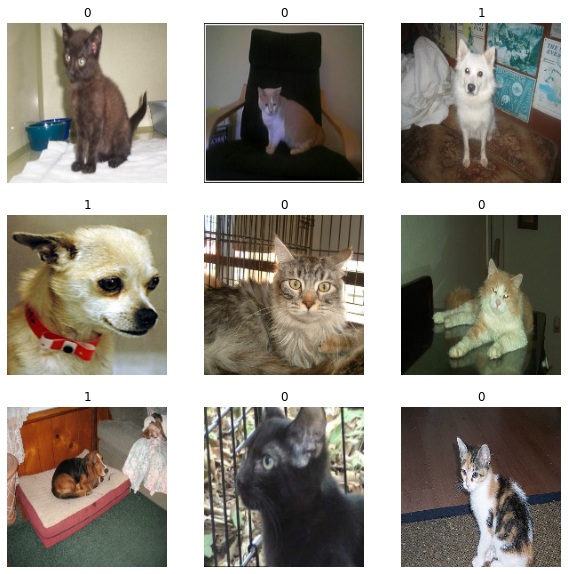

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Using image data augmentation

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

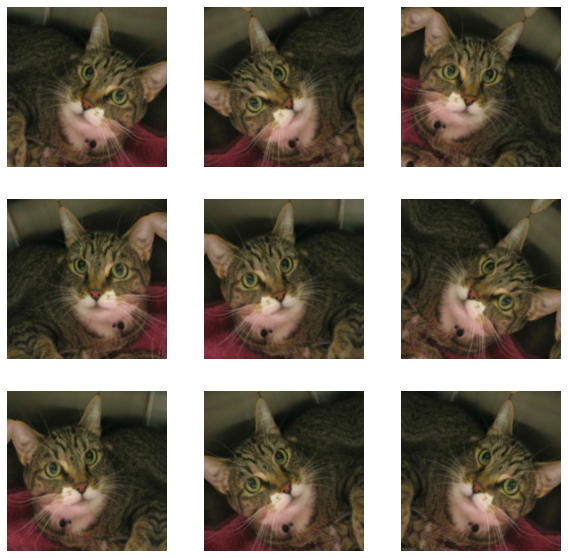

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# preprocess the data

In [17]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

# Configure the dataset for performance

In [18]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# Build a model

In [19]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [20]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
586/586 [==============================] - 105s 165ms/step - loss: 0.6278 - accuracy: 0.6611 - val_loss: 0.9721 - val_accuracy: 0.5120
Epoch 2/50


c:\users\user\pycharmprojects\pythonproject1\venv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


586/586 [==============================] - 96s 163ms/step - loss: 0.4572 - accuracy: 0.7905 - val_loss: 0.5941 - val_accuracy: 0.7372
Epoch 3/50
586/586 [==============================] - 95s 162ms/step - loss: 0.3707 - accuracy: 0.8338 - val_loss: 1.1509 - val_accuracy: 0.6659
Epoch 4/50
586/586 [==============================] - 96s 163ms/step - loss: 0.3155 - accuracy: 0.8643 - val_loss: 0.2847 - val_accuracy: 0.8894
Epoch 5/50
586/586 [==============================] - 95s 162ms/step - loss: 0.2636 - accuracy: 0.8882 - val_loss: 0.2287 - val_accuracy: 0.9080
Epoch 6/50
586/586 [==============================] - 95s 162ms/step - loss: 0.2306 - accuracy: 0.9038 - val_loss: 0.1875 - val_accuracy: 0.9255
Epoch 7/50
586/586 [==============================] - 95s 162ms/step - loss: 0.2137 - accuracy: 0.9109 - val_loss: 0.2735 - val_accuracy: 0.8851
Epoch 8/50
586/586 [==============================] - 96s 164ms/step - loss: 0.1931 - accuracy: 0.9197 - val_loss: 0.1753 - val_accuracy: 0.9

In [31]:
img = keras.preprocessing.image.load_img(
    "PetImages/Dog/12499.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 0.00 percent cat and 100.00 percent dog.
